## task2：实现ARMA模型预测

### 引入数据集

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 引入数据集
dataset = pd.read_csv('exp1_data/daily-min-temperatures.csv', index_col=0, parse_dates=[0]) # 指定索引为Date，并处理为日期格式
dataset.head(11)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


### 数据可视化

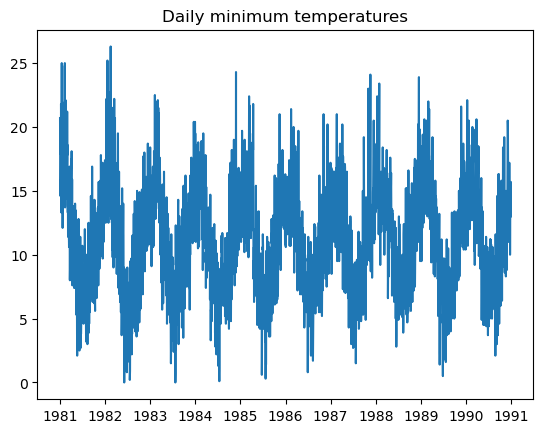

In [7]:
# 数据可视化
plt.plot(dataset.Temp)
plt.title('Daily minimum temperatures')
plt.show()

In [ ]:
# 数据预处理，插值
dataset = dataset.resample('D').interpolate(method='linear')  # 重采样，按天取平均值

定义绘图函数

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 定义绘图函数，画出原信号、ACF、PACF图
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 指定轴
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # 绘制图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series Analysis Plots')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()
    plt.show()
    return None

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


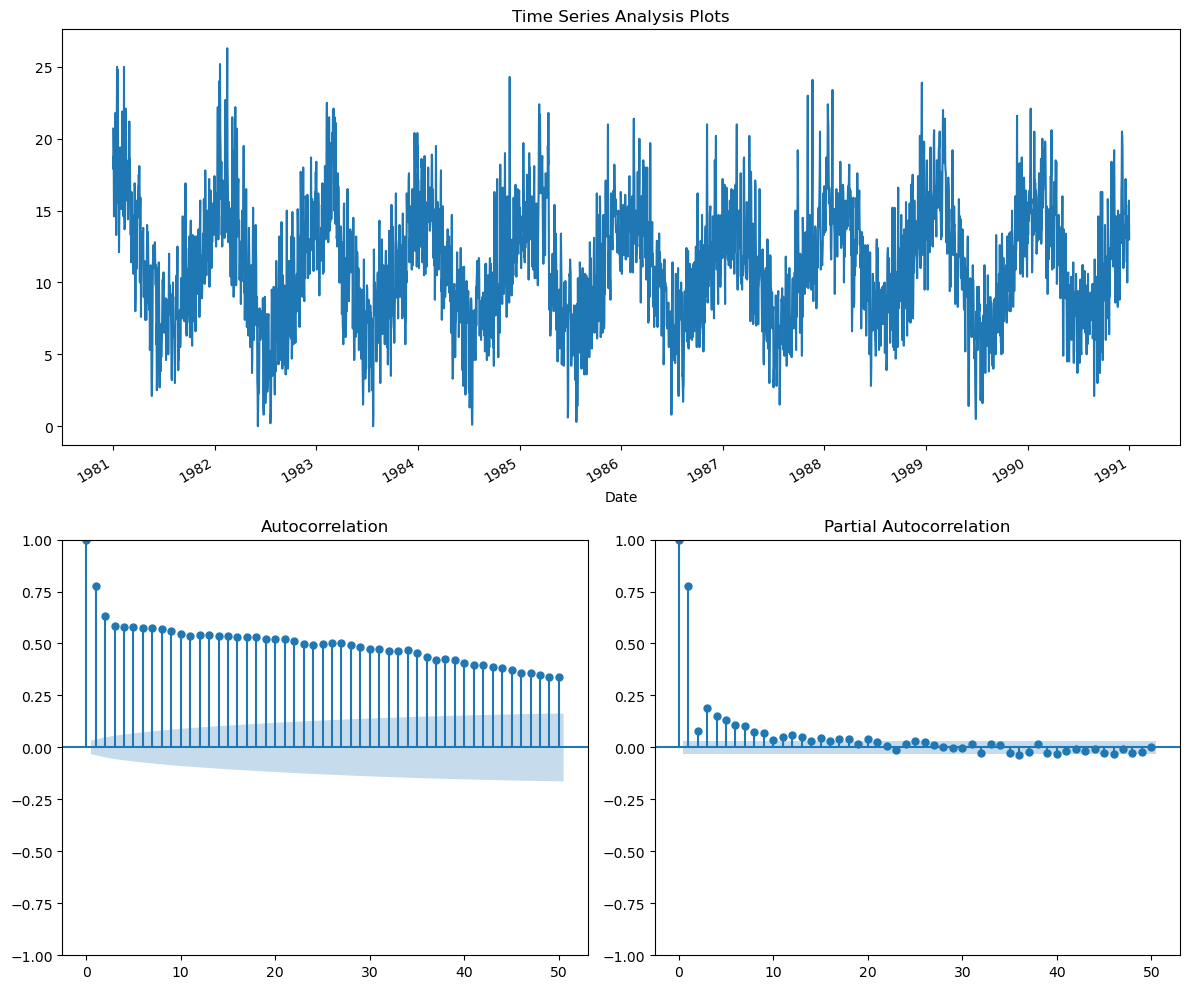

In [ ]:
# 画出三图
plotds(dataset.Temp, nlag=50)

### 构建AR模型

模型的识别和定阶

模型预测

预测值与真实值对比

### 构建MA模型

模型的识别和定阶

模型预测

预测值与真实值对比

### 构建ARMA模型

模型的识别和定阶

In [ ]:
from statsmodels.tsa.stattools import adfuller as ADF
diff = 0
# 采用单位根检验ADF检验时序是否平稳
def ADF_test(series):
    adf = ADF(series)
    if adf[1] > 0.05:
        print('序列是不平稳的,p为:', adf[1])
    else:
        print('序列是平稳的,p为:', adf[1])
        
ADF_test(dataset.Temp)

序列是平稳的,p为: 0.00024708263003610177


根据ACF、PACF图可以发现均为拖尾的，因此我们采用ARMA模型，并想要进一步确定模型阶数

In [ ]:
import statsmodels.tsa.api as smtsa

aicVal = []
for ari in range(0,3):
    for maj in range(0,3):
        try:
            arma_obj = smtsa.ARIMA(dataset.Temp.tolist(), order=(ari, 0, maj)).fit(method='innovations_mle')
            print(arma_obj.summary())
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)

print(aicVal)
min_aic = min(aicVal, key=lambda x: x[2])
best_ari = min_aic[0]
best_maj = min_aic[1]

print("Best AR order (ari): ", best_ari)
print("Best MA order (maj): ", best_maj)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3650
Model:                          ARIMA   Log Likelihood              -10303.569
Date:                Sun, 15 Sep 2024   AIC                          20611.139
Time:                        11:37:51   BIC                          20623.544
Sample:                             0   HQIC                         20615.557
                               - 3650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1778      0.068    164.595      0.000      11.045      11.311
sigma2        16.5753      0.397     41.701      0.000      15.796      17.354
Ljung-Box (L1) (Q):                2189.94   Jarque-

利用AIC准则，选择AIC最小的阶数作为ARMA(p,q)的模型，即p=2,q=2

In [ ]:
model = smtsa.ARIMA(dataset.Temp, order=(best_ari, 0, best_maj))
model_fit = model.fit()
print(model_fit.summary())

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3650
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8384.568
Date:                Sun, 15 Sep 2024   AIC                          16781.136
Time:                        11:39:11   BIC                          16818.351
Sample:                             0   HQIC                         16794.389
                               - 3650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4839      0.812     14.147      0.000       9.893      13.075
ar.L1          1.2365      0.040     30.766      0.000       1.158       1.315
ar.L2         -0.2421      0.040     -6.108      0.0

模型预测与拟合

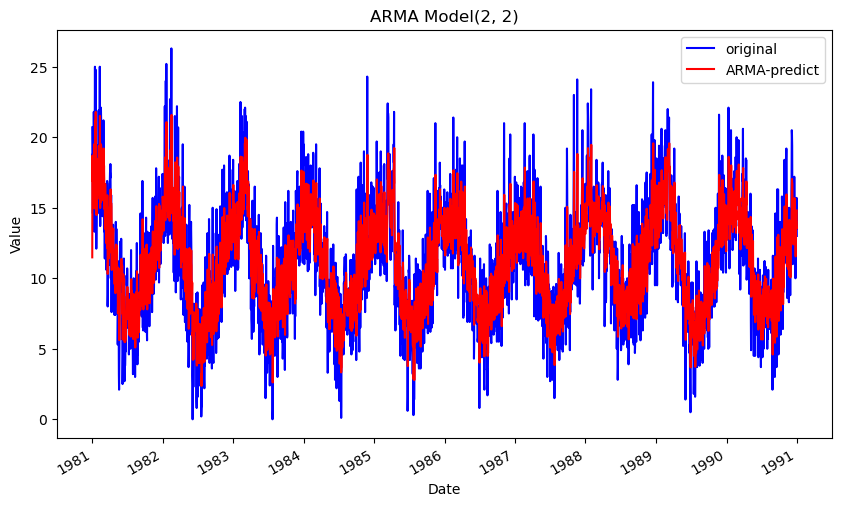

In [ ]:
# 将拟合结果存储到data变量，列名命名为ARMA
dataset['ARMA'] = model_fit.predict(typ='levels',dynamic=False)
fig, ax = plt.subplots(1, sharex=True)
fig.set_size_inches(10, 6)

# 画出真实数据图像
dataset['Temp'].plot(ax=ax, label='original', color='blue')
# 画出拟合数据图像
dataset['ARMA'].plot(ax=ax, label='ARMA-predict', color='red')
ax.set_title('ARMA Model(%s, %s)' % (best_ari, best_maj))

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

预测值与真实值对比